In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import os
import time
from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets,transforms

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._body = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
                               nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2),
                               nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
                               nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2))
        self._head = nn.Sequential(nn.Linear(in_features=16*5*5,out_features=120),nn.ReLU(inplace=True),
                               nn.Linear(in_features=120,out_features=84),nn.ReLU(inplace=True),
                               nn.Linear(in_features=84,out_features=10))
    
    def forward(self,x):
        x = self._body(x)
        x = x.view(x.size()[0],-1)
        x = self._head(x)
        return x

In [8]:
lenet5_model = LeNet5()
print(lenet5_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [9]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scales image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.1307) and divide by variance (0.3081).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

In [10]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True

In [11]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data/mnist-data)
    num_workers: int = 10  # number of concurrent processes used to prepare data
    device: str = 'cuda'

In [12]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [14]:
def train(train_config: TrainingConfiguration,model:nn.Module,optimizer:torch.optim.Optimizer,
         train_loader: torch.utils.data.DataLoader,epoch_idx:int) -> None:
    model.train()
    batch_loss = np.array([])
    batch_acc = np.array([])
    for batch_idx,(data,target) in enumerate(train_loader):
        indx_target = target.clone()
        data = data.to(train_config.device)
        target = target.to(train_config.device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        loss.backward()
        optimizer.step()
        batch_loss = np.append(batch_loss,[loss.item()])
        prob = F.softmax(output,dim=1)
        pred = prob.data.max(dim=1)[1]
        correct = pred.cpu().eq(indx_target).sum()
        acc = float(correct)/float(len(data))
        batch_acc = np.append(batch_acc,[acc])
        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print('Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'
                  .format(epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc))
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

In [15]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

In [16]:
def main(system_configuration=SystemConfiguration(),training_configuration=TrainingConfiguration()):
    setup_system(system_configuration)
    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.epochs_count
    
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5
    
    train_loader,test_loader = get_data(batch_size=batch_size_to_set,data_root=training_configuration.data_root,
                                       num_workers=num_workers_to_set)
    
    training_configuration = TrainingConfiguration(device=device,epochs_count=epoch_num_to_set,
                                                   batch_size=batch_size_to_set,num_workers=num_workers_to_set)
    
    model=LeNet5()
    model.to(training_configuration.device)
    optimizer=optim.SGD(model.parameters(),lr=training_configuration.learning_rate)
    
    best_loss = torch.tensor(np.inf)
    epoch_train_loss=np.array([])
    epoch_test_loss=np.array([])
    epoch_train_acc=np.array([])
    epoch_test_acc=np.array([])
    
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        train_loss,train_acc=train(training_configuration,model,optimizer,train_loader,epoch)
        epoch_train_loss=np.append(epoch_train_loss,[train_loss])
        epoch_train_acc=np.append(epoch_train_acc,[train_acc])
        elapsed_time=time.time()-t_begin
        speed_epoch=elapsed_time/(epoch+1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [17]:
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

Train Epoch: 0 [1600/60000] Loss: 2.243848 Acc: 0.4375
Train Epoch: 0 [3200/60000] Loss: 2.018941 Acc: 0.5000
Train Epoch: 0 [4800/60000] Loss: 0.985802 Acc: 0.6875
Train Epoch: 0 [6400/60000] Loss: 0.340875 Acc: 0.9375
Train Epoch: 0 [8000/60000] Loss: 0.694390 Acc: 0.8125
Train Epoch: 0 [9600/60000] Loss: 0.207748 Acc: 0.9375
Train Epoch: 0 [11200/60000] Loss: 0.459668 Acc: 0.8125
Train Epoch: 0 [12800/60000] Loss: 0.240003 Acc: 0.9375
Train Epoch: 0 [14400/60000] Loss: 0.170324 Acc: 0.9375
Train Epoch: 0 [16000/60000] Loss: 0.595128 Acc: 0.8125
Train Epoch: 0 [17600/60000] Loss: 0.133479 Acc: 0.9375
Train Epoch: 0 [19200/60000] Loss: 0.052866 Acc: 1.0000
Train Epoch: 0 [20800/60000] Loss: 0.198849 Acc: 0.9375
Train Epoch: 0 [22400/60000] Loss: 0.550820 Acc: 0.8125
Train Epoch: 0 [24000/60000] Loss: 0.035258 Acc: 1.0000
Train Epoch: 0 [25600/60000] Loss: 0.098799 Acc: 1.0000
Train Epoch: 0 [27200/60000] Loss: 0.035301 Acc: 1.0000
Train Epoch: 0 [28800/60000] Loss: 0.163770 Acc: 0.937

Train Epoch: 3 [49600/60000] Loss: 0.084592 Acc: 0.9375
Train Epoch: 3 [51200/60000] Loss: 0.002252 Acc: 1.0000
Train Epoch: 3 [52800/60000] Loss: 0.040321 Acc: 1.0000
Train Epoch: 3 [54400/60000] Loss: 0.020212 Acc: 1.0000
Train Epoch: 3 [56000/60000] Loss: 0.000612 Acc: 1.0000
Train Epoch: 3 [57600/60000] Loss: 0.001874 Acc: 1.0000
Train Epoch: 3 [59200/60000] Loss: 0.040057 Acc: 1.0000
Elapsed 143.97s, 35.99 s/epoch, 0.01 s/batch, ets 35.99s

Test set: Average loss: 0.0370, Accuracy: 9879/10000 (99%)

Train Epoch: 4 [1600/60000] Loss: 0.000366 Acc: 1.0000
Train Epoch: 4 [3200/60000] Loss: 0.000115 Acc: 1.0000
Train Epoch: 4 [4800/60000] Loss: 0.062603 Acc: 1.0000
Train Epoch: 4 [6400/60000] Loss: 0.294354 Acc: 0.8125
Train Epoch: 4 [8000/60000] Loss: 0.001763 Acc: 1.0000
Train Epoch: 4 [9600/60000] Loss: 0.005324 Acc: 1.0000
Train Epoch: 4 [11200/60000] Loss: 0.006524 Acc: 1.0000
Train Epoch: 4 [12800/60000] Loss: 0.005671 Acc: 1.0000
Train Epoch: 4 [14400/60000] Loss: 0.029465 Acc:

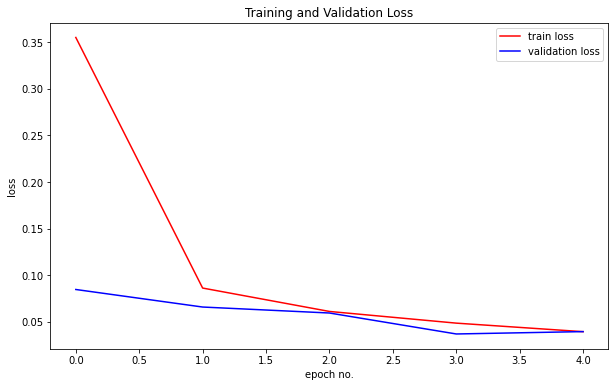

In [18]:
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

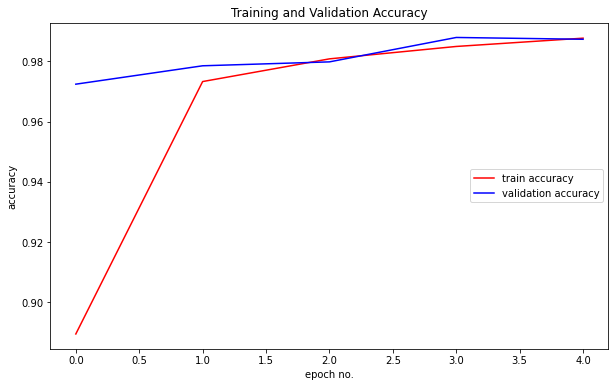

In [19]:
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')
plt.show()

In [20]:
models = 'models'
if not os.path.exists(models):
    os.makedirs(models)
    
model_file_name = 'lenet5_mnist.pt'

model_path = os.path.join(models, model_file_name)

# make sure you transfer the model to cpu.
model.to('cpu')

# save the state_dict
torch.save(model.state_dict(), model_path)

In [21]:
lenet5_mnist = LeNet5()

# loading the model and getting model parameters by using load_state_dict
lenet5_mnist.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [23]:
def prediction(model, train_config, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(train_config.device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(train_config.device)

    output = model(data)

    # get probability score using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

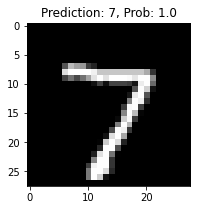

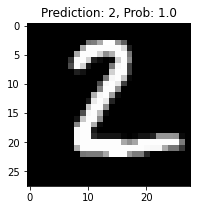

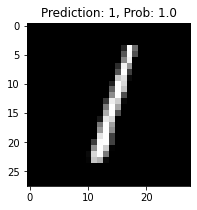

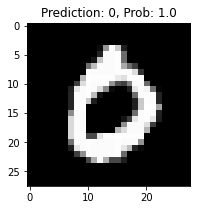

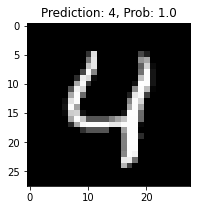

In [24]:
batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"

# load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, 
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(lenet5_mnist, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, _ in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img, cmap='gray')
        plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
        plt.show()
    break